# Estudio de la evolución de la pandemia por el modelo ARIMA para la isla de Lanzarote

In [1]:
# Carga inicial de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def visualizar_STL(df):
    stl = STL(df, period=12)
    res = stl.fit()
    
    fig = res.plot()

    
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator(interval=1))

    plt.xticks(rotation=90)
    plt.show()
    

def visualizar_adf(df):
    ''' Visualiza el p-valor del estudio de Dickey-Fuller para determinar la estacionalidad de los datos
    
    Args:
        df (DataFrame): DataFrame con los datos a realizar el estudio (DataFrame con una única columna que es la objetivo)
    '''

    adf = adfuller(df)
    print("ADF p-value:" + str(adf[1]))
    

def visualizar_acf(df, n_lags):
    plt.figure(figsize=(16, 10))
    plot_acf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación')
    plt.title('ACF')
    plt.show()
    
def visualizar_pacf(df, n_lags):
    plt.figure(figsize=(16, 6))
    plot_pacf(df, lags=n_lags)
    plt.xlabel('Rezagos')
    plt.ylabel('Autocorrelación parcial')
    plt.title('PACF')
    plt.show()
    
    
def visualizar_dif_pred_test(test, pred, variable, tit):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
    
    Args:
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
        tit(string): título del gráfico
    '''
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(test.index, test, label='Test', color='green')
    plt.plot(test.index, pred, label='Predicción', color='orange')

    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.xticks(rotation=60)
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
def visualizar_historico(train, test, pred, variable, dias_historico, tit, color, dif):
    ''' Método que visualiza un gráfico con la comparativa entre el número de casos reales y los predichos
        y muestra el historico de casos en función del número de días que indiquemos que muestre
    
    Args:
        train (DataFrame): Conjunto de datos de entrenamiento
        test (DataFrame): Valores reales del conjunto de test
        pred (Serie): Valores predichos por el modelo
        variable (string): Variable objetivo
        dias_historico (integer): días hacia atrás a mostrar del historico
        tit (string): título del gráfico
        color (string): color de la isla para visualizar
    '''
    train_s = train.iloc[len(train) - dias_historico:]
    
    plt.figure(figsize=(10, 6))

    if variable != '':
        plt.plot(train_s.index, train_s[variable], label='Train', color=color)
        plt.plot(test.index, test[variable], label='Test', color='green')
    else:
        plt.plot(train_s.index, train_s, label='Train', color=color)
        plt.plot(test.index, test, label='Test', color='green')
    
    plt.plot(test.index, pred, label='Predicción', color='orange')
    plt.bar(test.index, dif, width=0.5, color='black', alpha=0.2, align='edge', label='Diferencia')
    
    
    plt.xticks(np.arange(0, len(train_s.index)  + len(test.index), step=5),   train_s.index.union(test.index)[::5], rotation=70)
    plt.gca().set_facecolor('lightgrey')
    plt.grid(True, linestyle='--', linewidth=0.5, color='white')
    plt.legend()
    plt.title(tit)
    plt.xlabel('Fecha')
    plt.ylabel('Número de casos de COVID')
    plt.show()
    
    
def obtener_errores(y_true, y_pred):
    ''' Método que devuelvo los errores:
            * MAE: Error absoluto medio
            * MSE: Error cuadrático medio
            * RMSE: Raíz del error cuadrático medio
    
    Args:
        y_true (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
    Return:
        mae(float): Error absoluto medio
        mse(float): Error cuadrático medio
        rmse(float): Raíz del error cuadrático medio
    '''
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

def visualizar_bic_aic(modelo):
    ''' Visualiza los datos de BIC (Criterio de Información Bayesiano) y  AIC (Criterio de Información de Akaike)
    
    Args:
        modelo (ARIMA): modelo ARIMA entrenado
    '''
    
    bic = modelo.bic
    aic = modelo.aic

    print("BIC del modelo ARIMA:", bic)
    print("AIC del modelo ARIMA:", aic)
    
def visualizar_resultados_texto(y_test, y_pred, variable):
    ''' Método que visualiza por pantalla en formato de texto el número de csaos reales y los predichos por el algoritmo
    
    Args:
        y_test (Serie): Valores reales del conjunto de test
        y_pred (Serie): Valores predichos por el modelo
        variable(string): Variable objetivo
    '''
    fechas = y_test.index
    for i in range(len(y_test)):
        if variable != '':
            valor_test = y_test[variable][i]
        else:
            valor_test = y_test[i] 
        print(str(fechas[i]) + ': número de casos reales ' + str(valor_test) + ', número de casos predichos ' + str(y_pred[i]))
        
def obtener_df_diferencias(test, pred, variable):
    df_result = test.copy()
    if variable != '':
        df_result = df_result[variable]
        df_result = df_result.to_frame()
    else:
        df_result = df_result.to_frame()
    df_result['pred'] = 0
    df_result['dif'] = 0

    for i in range(len(df_result)):
        df_result.iloc[i, df_result.columns.get_loc('pred')] = pred[i]
        df_result.iloc[i, df_result.columns.get_loc('dif')] = df_result['numero_casos'][i] - pred[i]
        
    return df_result

In [3]:
# Cargamos los datos de las estaciones de cada una de las islas
datos_islas = pd.read_csv('../data/Final/datos_reduc_final.csv', header=0)

# Obtenemos los datos de la isla a la que se le va a realizar el estudio
datos_Lanzarote = datos_islas[datos_islas['isla'] == 'LANZAROTE'].copy()


datos_Lanzarote = datos_Lanzarote.sort_values(by='fecha')     # Ordenamos por fecha por si los datos devueltos no estuvieran en orden
datos_Lanzarote.set_index('fecha', inplace=True)              # Añadimos como índice de los datos la fecha

In [4]:
# Variables globales a utilizar en todo el proceso

objetivo = 'numero_casos' # Variable objetivo
n_dias = 10               # Numero de días correspondiente al conjunto de TEST
n_dias_train_vis = 100    # Número de días del conjunto de train a visualizar en el conjunto de train
color_isla = 'firebrick'        # Color de la isla en las visualizaciones
isla = 'Lanzarote'        # Nombre de la isla para las visualizaciones  

variables_covid = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19']   # Atributos para el análisis de las variables pandémicas
variables_atm = ['tmin', 'tmed', 'presMax']                         # Atributos para el análisis de las variables atmosféricas
variables = ['pcr_total', 'Urg_cv', 'HPT_cv19', 'CCR_cv19','tmin', 'tmed', 'presMax'] # Atributos para el análisis de todas las variables

In [5]:
# Obtenemos los conjuntos de datos para cada modelo con las variables necesarias para cada uno de ellos
# Modelo Univariable
datos_Lanzarote_arima_uni = datos_Lanzarote[objetivo]  # Datos modelo Univariable
datos_Lanzarote_arima_mult_covid = datos_Lanzarote[[objetivo] + variables_covid] # Datos modelo Multivariable con datos pandémicos
datos_Lanzarote_arima_mult_atm = datos_Lanzarote[[objetivo] + variables_atm]     # Datos modelo Multivariable con datos atmosféricos
datos_Lanzarote_arima_total = datos_Lanzarote.copy()                # Datos modelo Multivariable con todos los datos

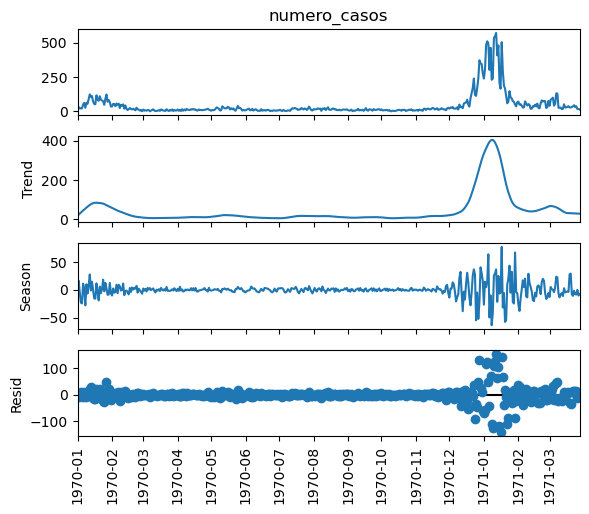

In [6]:
visualizar_STL(datos_Lanzarote_arima_uni)

In [7]:
visualizar_adf(datos_Lanzarote_arima_uni)

ADF p-value:0.00933232754339828


Dado que el pvalor es inferior a 0.05 es una serie temporal estacionaria

<Figure size 1600x1000 with 0 Axes>

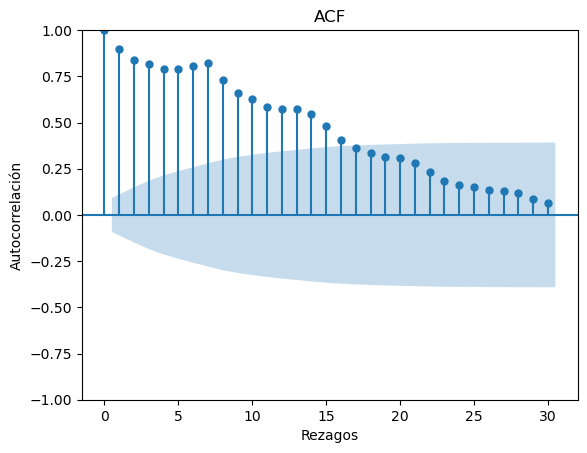

In [8]:
visualizar_acf(datos_Lanzarote_arima_uni, 30)

<Figure size 1600x600 with 0 Axes>

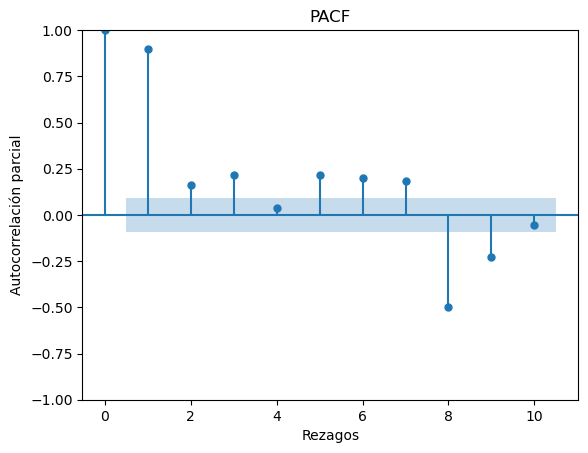

In [9]:
visualizar_pacf(datos_Lanzarote_arima_uni, 10)

In [10]:
# Parámetros del modelo ARIMA
p = 1   # Parámetro Autorregresivo (AR)
d = 0   # Parámetro Integrado (I)
q = 3   # Parámetro Promedio Movil (MA)

# Modelo ARIMA univariable

In [11]:
# Conjuntos de entrenamiento y test
train = datos_Lanzarote_arima_uni.iloc[:len(datos_Lanzarote_arima_uni) - n_dias]
test =  datos_Lanzarote_arima_uni.iloc[len(datos_Lanzarote_arima_uni) - n_dias:]

In [12]:
arima_Lanzarote = ARIMA(endog=train, order=(p, d, q), freq = 'D')
modelo_arima_Lanzarote = arima_Lanzarote.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [13]:
visualizar_bic_aic(modelo_arima_Lanzarote)

BIC del modelo ARIMA: 4465.8751527364275
AIC del modelo ARIMA: 4441.327293443961


In [14]:
pred = modelo_arima_Lanzarote.forecast(steps=n_dias)

In [15]:
visualizar_resultados_texto(test, pred, '')

2022-03-19: número de casos reales 28, número de casos predichos 36.865409524542855
2022-03-20: número de casos reales 27, número de casos predichos 34.51345826995774
2022-03-21: número de casos reales 32, número de casos predichos 35.412353312185914
2022-03-22: número de casos reales 35, número de casos predichos 35.65716080354711
2022-03-23: número de casos reales 44, número de casos predichos 35.89540847594531
2022-03-24: número de casos reales 30, número de casos predichos 36.12727210514861
2022-03-25: número de casos reales 36, número de casos predichos 36.35292275686818
2022-03-26: número de casos reales 16, número de casos predichos 36.57252691296816
2022-03-27: número de casos reales 17, número de casos predichos 36.78624659429359
2022-03-28: número de casos reales 13, número de casos predichos 36.994239480207135


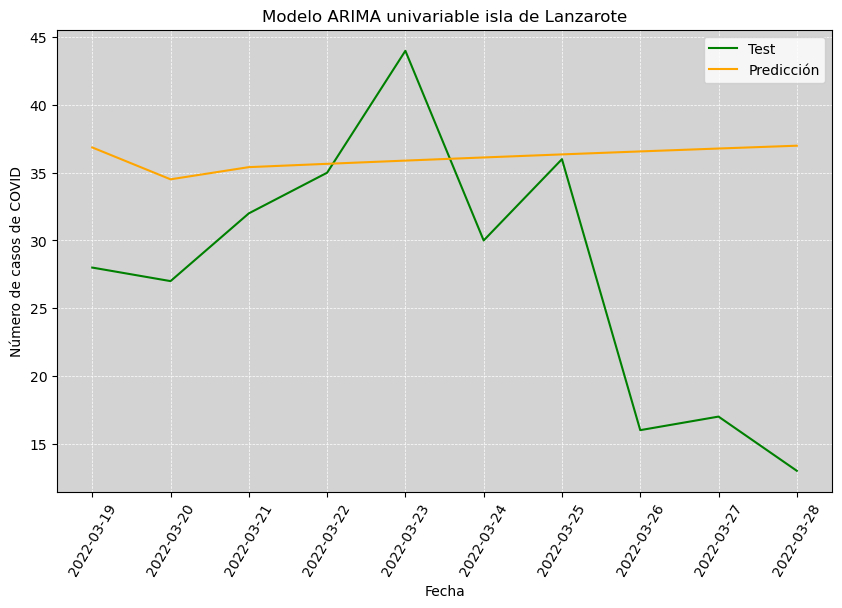

In [16]:
# Título para las visualizaciones
tit = 'Modelo ARIMA univariable isla de ' + isla
visualizar_dif_pred_test(test, pred, '', tit)

In [17]:
df_result = obtener_df_diferencias(test, pred, '')
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,28,36.865410,-8.865410
2022-03-20,27,34.513458,-7.513458
2022-03-21,32,35.412353,-3.412353
2022-03-22,35,35.657161,-0.657161
2022-03-23,44,35.895408,8.104592
2022-03-24,30,36.127272,-6.127272
2022-03-25,36,36.352923,-0.352923
2022-03-26,16,36.572527,-20.572527
2022-03-27,17,36.786247,-19.786247


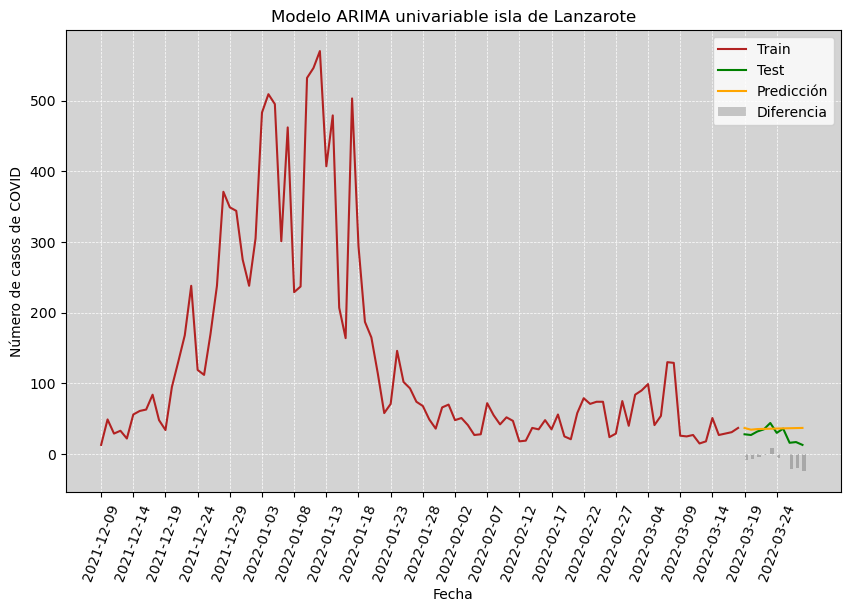

In [18]:
visualizar_historico(train, test, pred, '', n_dias_train_vis, tit,color_isla, df_result['dif'])

In [19]:
mae, mse, rmse = obtener_errores(test, pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 164.09239244643078
Error absoluto medio (MAE) del modelo: 9.9386181283774
Raíz del error cuadrático medio (RMSE) del modelo: 12.809855285928517


# Modelo ARIMA multivariable con variables de pandemia

In [20]:
train = datos_Lanzarote_arima_mult_covid.iloc[:len(datos_Lanzarote_arima_mult_covid) - n_dias]
test =  datos_Lanzarote_arima_mult_covid.iloc[len(datos_Lanzarote_arima_mult_covid) - n_dias:]

In [21]:
arima_Lanzarote = ARIMA(endog=train[objetivo],exog=train[variables_covid], order=(p, d, q), freq = 'D')
modelo_arima_Lanzarote = arima_Lanzarote.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
visualizar_bic_aic(modelo_arima_Lanzarote)

BIC del modelo ARIMA: 4276.505640978241
AIC del modelo ARIMA: 4235.592542157464


In [23]:
pred = modelo_arima_Lanzarote.forecast(steps=n_dias, exog=test[variables_covid])

In [24]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 28, número de casos predichos 20.32306747264326
2022-03-20: número de casos reales 27, número de casos predichos -6.822267855227523
2022-03-21: número de casos reales 32, número de casos predichos 16.538934959551053
2022-03-22: número de casos reales 35, número de casos predichos -3.8587330834008924
2022-03-23: número de casos reales 44, número de casos predichos -13.520561281907561
2022-03-24: número de casos reales 30, número de casos predichos -6.41602001451097
2022-03-25: número de casos reales 36, número de casos predichos -16.15637861040411
2022-03-26: número de casos reales 16, número de casos predichos -15.273867643423927
2022-03-27: número de casos reales 17, número de casos predichos -19.244324634572394
2022-03-28: número de casos reales 13, número de casos predichos 0.8222990056550756


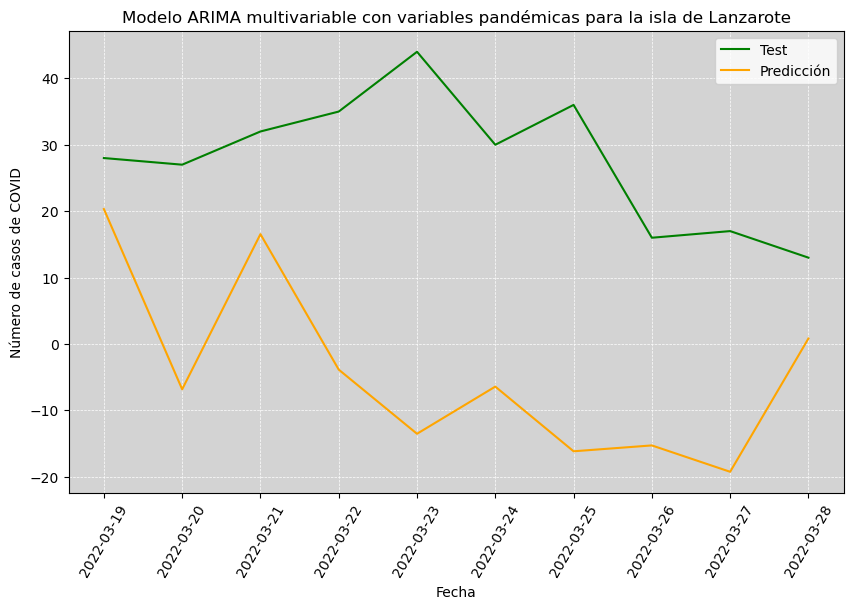

In [25]:
tit = 'Modelo ARIMA multivariable con variables pandémicas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [26]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,28,20.323067,7.676933
2022-03-20,27,-6.822268,33.822268
2022-03-21,32,16.538935,15.461065
2022-03-22,35,-3.858733,38.858733
2022-03-23,44,-13.520561,57.520561
2022-03-24,30,-6.416020,36.416020
2022-03-25,36,-16.156379,52.156379
2022-03-26,16,-15.273868,31.273868
2022-03-27,17,-19.244325,36.244325


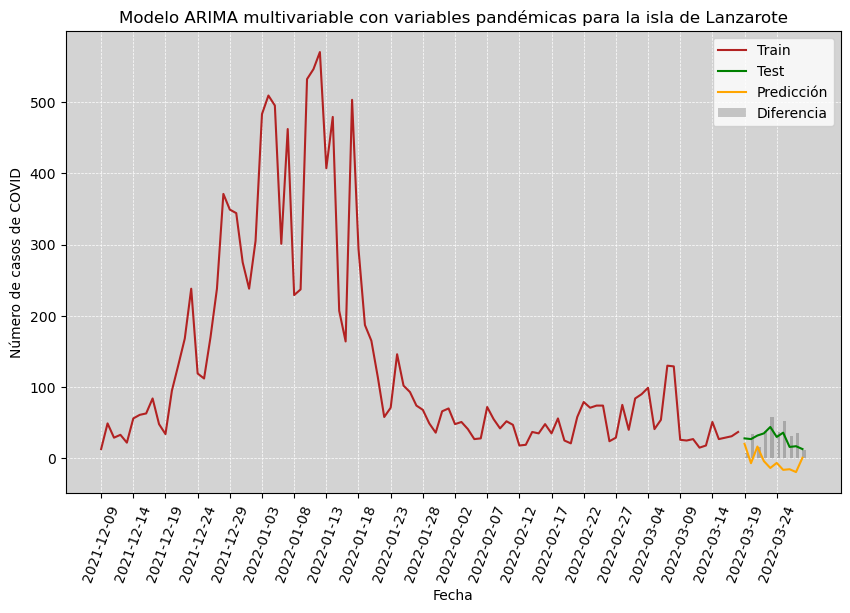

In [27]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit,color_isla, df_result['dif'])

In [28]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1274.6958345669439
Error absoluto medio (MAE) del modelo: 32.1607851685598
Raíz del error cuadrático medio (RMSE) del modelo: 35.702882720684386


# Modelo ARIMA multivariable con variables atmosféricas

In [29]:
train = datos_Lanzarote_arima_mult_atm.iloc[:len(datos_Lanzarote_arima_mult_atm) - n_dias]
test =  datos_Lanzarote_arima_mult_atm.iloc[len(datos_Lanzarote_arima_mult_atm) - n_dias:]

In [30]:
arima_Lanzarote = ARIMA(endog=train[objetivo],exog=train[variables_atm], order=(p, d, q), freq = 'D')
modelo_arima_Lanzarote = arima_Lanzarote.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [31]:
visualizar_bic_aic(modelo_arima_Lanzarote)

BIC del modelo ARIMA: 4510.719496657753
AIC del modelo ARIMA: 4473.897707719053


In [32]:
pred = modelo_arima_Lanzarote.forecast(steps=n_dias, exog=test[variables_atm])

In [33]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 28, número de casos predichos 27.638952299864723
2022-03-20: número de casos reales 27, número de casos predichos 40.34148445906341
2022-03-21: número de casos reales 32, número de casos predichos 46.98406764536623
2022-03-22: número de casos reales 35, número de casos predichos 46.9256984593478
2022-03-23: número de casos reales 44, número de casos predichos 34.557970143017236
2022-03-24: número de casos reales 30, número de casos predichos 23.989784760777283
2022-03-25: número de casos reales 36, número de casos predichos 5.591483193093959
2022-03-26: número de casos reales 16, número de casos predichos 7.786343375231588
2022-03-27: número de casos reales 17, número de casos predichos -20.274556636024123
2022-03-28: número de casos reales 13, número de casos predichos -7.857607917595484


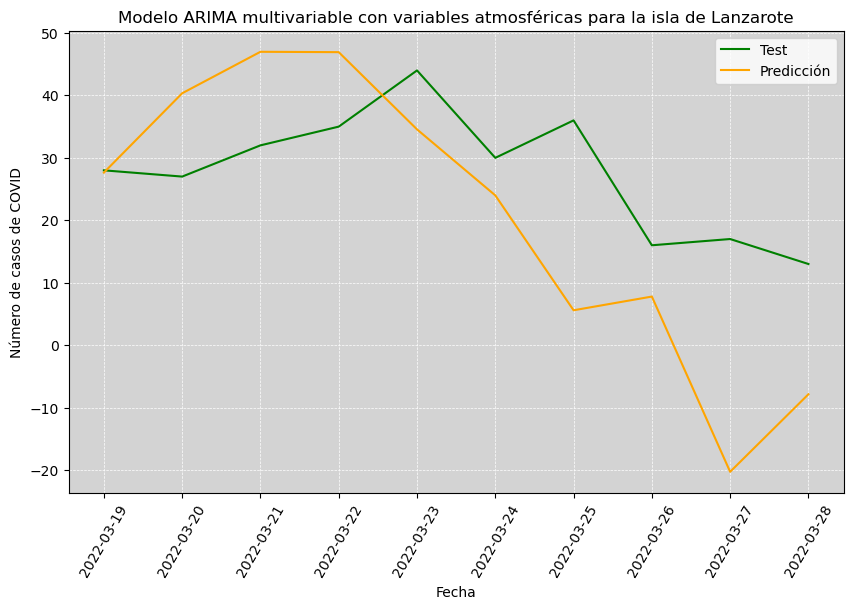

In [34]:
tit = 'Modelo ARIMA multivariable con variables atmosféricas para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [35]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,28,27.638952,0.361048
2022-03-20,27,40.341484,-13.341484
2022-03-21,32,46.984068,-14.984068
2022-03-22,35,46.925698,-11.925698
2022-03-23,44,34.557970,9.442030
2022-03-24,30,23.989785,6.010215
2022-03-25,36,5.591483,30.408517
2022-03-26,16,7.786343,8.213657
2022-03-27,17,-20.274557,37.274557


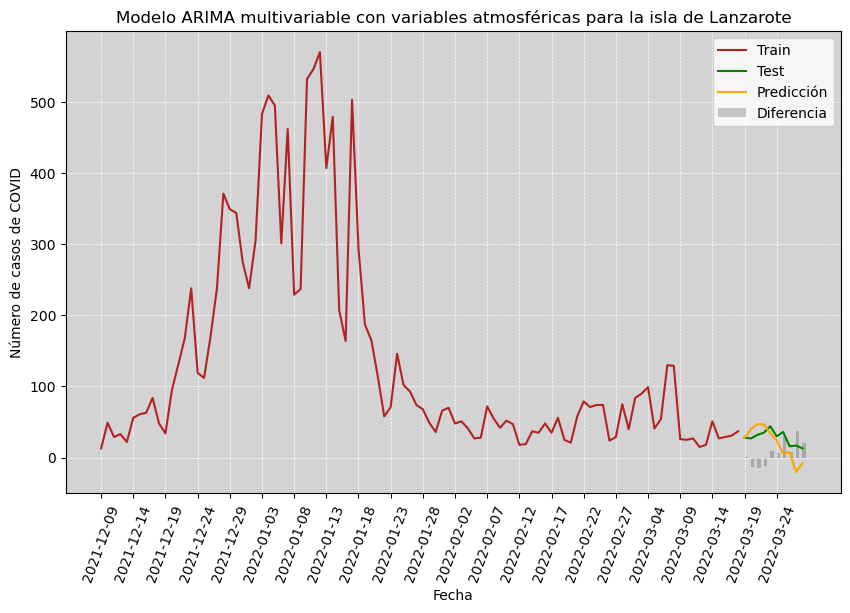

In [36]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit,color_isla, df_result['dif'])

In [37]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 348.67191750011455
Error absoluto medio (MAE) del modelo: 15.281888134541228
Raíz del error cuadrático medio (RMSE) del modelo: 18.672758700848533


# Modelo ARIMA multivariable con todas las variables

In [38]:
train = datos_Lanzarote_arima_total.iloc[:len(datos_Lanzarote_arima_total) - n_dias]
test =  datos_Lanzarote_arima_total.iloc[len(datos_Lanzarote_arima_total) - n_dias:]

In [39]:
arima_Lanzarote = ARIMA(endog=train[objetivo],exog=train[variables], order=(p, d, q), freq = 'D')
modelo_arima_Lanzarote = arima_Lanzarote.fit()

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [40]:
visualizar_bic_aic(modelo_arima_Lanzarote)

BIC del modelo ARIMA: 4292.025520423451
AIC del modelo ARIMA: 4238.8384919564405


In [41]:
pred = modelo_arima_Lanzarote.forecast(steps=10, exog=test[variables])

In [42]:
visualizar_resultados_texto(test, pred, objetivo)

2022-03-19: número de casos reales 28, número de casos predichos 18.76230248070427
2022-03-20: número de casos reales 27, número de casos predichos -0.10355785816241347
2022-03-21: número de casos reales 32, número de casos predichos 28.361045613967384
2022-03-22: número de casos reales 35, número de casos predichos 9.05743487392219
2022-03-23: número de casos reales 44, número de casos predichos -3.9013652556976828
2022-03-24: número de casos reales 30, número de casos predichos 0.8406903402740671
2022-03-25: número de casos reales 36, número de casos predichos -14.841116061980863
2022-03-26: número de casos reales 16, número de casos predichos -12.50070161218855
2022-03-27: número de casos reales 17, número de casos predichos -30.1634253805028
2022-03-28: número de casos reales 13, número de casos predichos -3.360223912999177


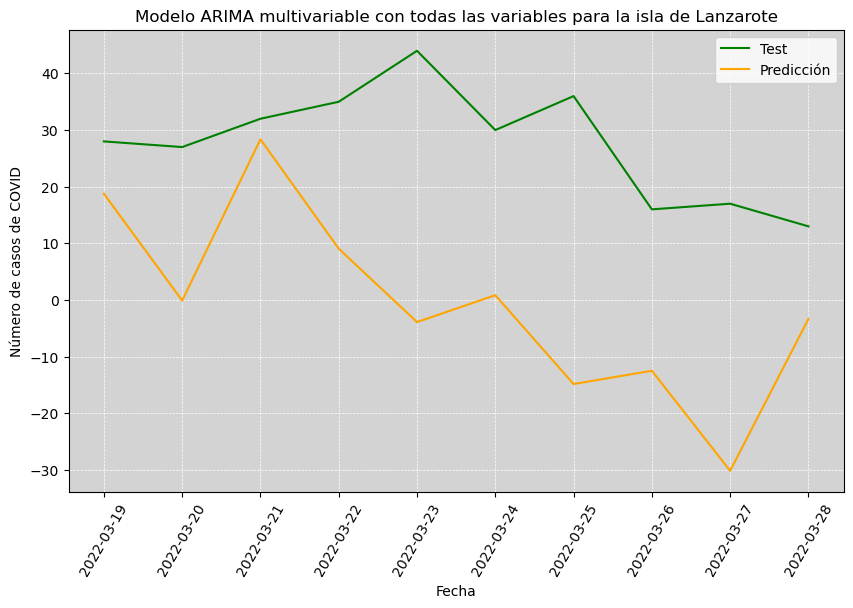

In [43]:
tit = 'Modelo ARIMA multivariable con todas las variables para la isla de ' + isla

visualizar_dif_pred_test(test, pred, objetivo, tit)

In [44]:
df_result = obtener_df_diferencias(test, pred, objetivo)
df_result

,numero_casos,pred,dif
fecha,,,
2022-03-19,28,18.762302,9.237698
2022-03-20,27,-0.103558,27.103558
2022-03-21,32,28.361046,3.638954
2022-03-22,35,9.057435,25.942565
2022-03-23,44,-3.901365,47.901365
2022-03-24,30,0.840690,29.159310
2022-03-25,36,-14.841116,50.841116
2022-03-26,16,-12.500702,28.500702
2022-03-27,17,-30.163425,47.163425


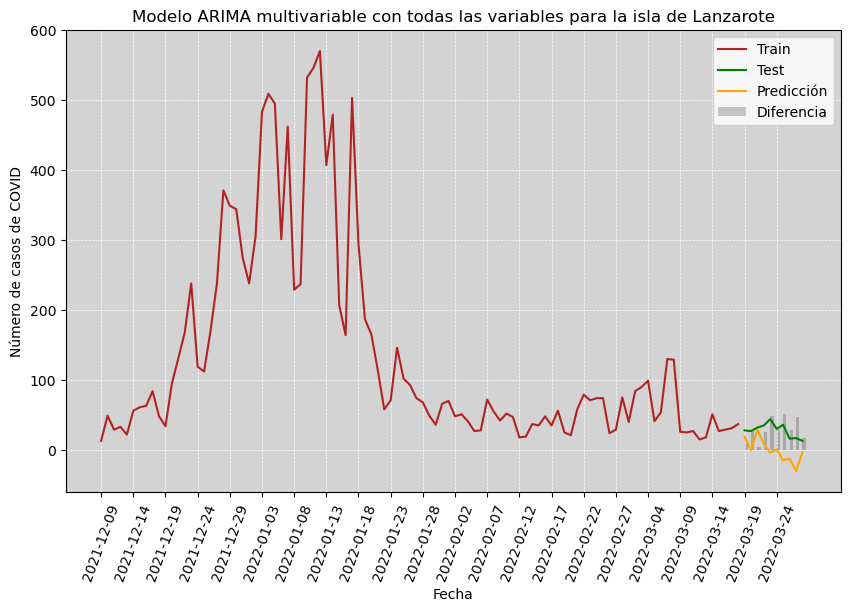

In [45]:
visualizar_historico(train, test, pred, objetivo, n_dias_train_vis, tit,color_isla, df_result['dif'])

In [46]:
mae, mse, rmse = obtener_errores(test[objetivo], pred)

print("Error cuadrático medio (MSE) del modelo: " + str(mse))
print("Error absoluto medio (MAE) del modelo: " + str(mae))
print("Raíz del error cuadrático medio (RMSE) del modelo: " + str(rmse))

Error cuadrático medio (MSE) del modelo: 1054.0157406485264
Error absoluto medio (MAE) del modelo: 28.58489167726636
Raíz del error cuadrático medio (RMSE) del modelo: 32.46560858275302
